In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from torchvision.utils import save_image

import pandas as pd

import random

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import offsetbox

from model_defs import *

import numpy as np

from itertools import chain

from sklearn import (manifold, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

In [2]:
emnist = datasets.EMNIST('./data', train = True, transform = transforms.ToTensor(), split = 'letters', download = True)
emnist_test = datasets.EMNIST('./data', train = False, transform = transforms.ToTensor(), split = 'letters', download = True)

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
%%time
df_train_ori = pd.DataFrame({'img': [e[0] for e in mnist_train], 'label': [e[1] for e in mnist_train]})
df_train = df_train_ori[df_train_ori.label == 0].reset_index().drop('index',axis = 1)

df_ref = pd.DataFrame({'img': [e[0] for e in emnist], 'label':[e[1] - 1 for e in emnist]})
df_ref_use = df_ref.sample(df_train.shape[0]).reset_index().drop('index', axis = 1)

df_ref_test = pd.DataFrame({'img': [e[0] for e in emnist_test], 'label':[e[1] - 1 for e in emnist_test]})
# df_ref_test = df_ref_test.sample(df_train.shape[0]).reset_index().drop('index', axis = 1)

CPU times: user 43.3 s, sys: 528 ms, total: 43.8 s
Wall time: 43.9 s


In [4]:
class Char_img(Dataset):
    def __init__(self, targ_data, ref_data):
        self.targ_img = targ_data.img
        self.targ_l = targ_data.label
        
        self.ref_img = ref_data.img
        self.ref_l = ref_data.label
    
    def __len__(self):
        return len(self.targ_l)
    
    def __getitem__(self, idx):
        
        n = min(len(self.targ_l)-1, idx)
        
        t_img = self.targ_img[n]
        t_lab = self.targ_l[n] == 0
        
        r_img = self.ref_img[idx]
        
        
        r_lab = torch.tensor(self.ref_l[idx])
        
        return t_img, t_lab, r_img, r_lab
        
        

In [5]:
# def compactness_loss(feat):
#     h = feat.view(feat.shape[0],-1)
#     m_ori = h.sum(axis = 0)

#     ms_t = torch.stack([m_ori] * h.shape[0])

#     ms = (ms_t - h)/(h.shape[0] - 1)
#     z = h - ms
#     lc = torch.matmul(z.T, z).sum()/(h.shape[0]*h.shape[1])
    
#     return lc

def compactness_loss(feat):
    h = feat.view(feat.shape[0],-1)
    std = h - h.mean(axis = 0)
    lc = h.shape[0]**2/(h.shape[0]*h.shape[1])*torch.sum(torch.matmul(std.T,std))/(h.shape[0]-1)**2
    
    return lc

In [6]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for _,_, data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output, _ = model(data)
            output = F.log_softmax(output, dim=1)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [7]:
batch_size = 64
learning_rate = 1e-3
num_epoch = 100

lam = 0.1

In [8]:
c_imgs = Char_img(df_train, df_ref)#Char_img(df_train, df_ref_use)
training_loader = DataLoader(c_imgs, batch_size = batch_size, shuffle = True)

In [9]:
c_imgs_test = Char_img(df_train, df_ref_test)
testing_loader = DataLoader(c_imgs_test, batch_size = batch_size, shuffle = True)

In [ ]:
model = One_class_net()
model.load_state_dict(torch.load('./rep_v1.pth'))
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [11]:
losses = []
for i in tqdm(range(num_epoch)): #num_epochs
    for t_img ,_, r_img, r_l in training_loader:
        r_img = r_img.cuda()
        r_l = r_l.cuda()
        
        t_img = t_img.cuda()

        r_output, _ = model(r_img)
        t_output, _ = model(t_img)
        
        loss = criterion(output, r_l) + lam*compactness_loss(t_out)

        losses.append(loss.mean().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

torch.save(model.state_dict(), './compact_v2.pth')

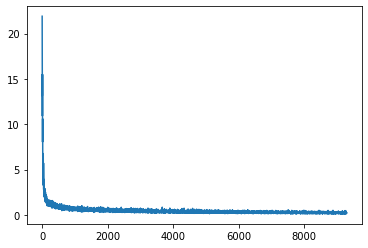

In [12]:
plt.plot(losses)

In [13]:
test(model, testing_loader)


Test set: Average loss: 0.8158, Accuracy: 4560/5923 (77%)



In [3]:
t = torch.tensor([[1,2,3],[4,5,6]])
print(t.shape)

torch.Size([2, 3])


In [4]:
t.sum(axis = 0).shape

torch.Size([3])